In [1]:
from qpms import *

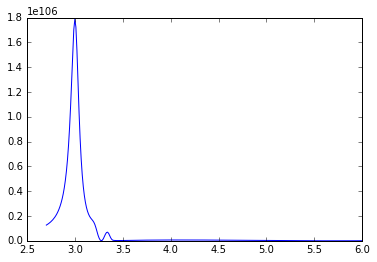

In [2]:
#Single atom near a nanoparticle, as in PRL 112, 253601. We want to reproduce part of figure 4.

#The ordering of R, r_n arguments in eq. (4) has to be checked

%matplotlib inline
import matplotlib.pyplot as plt

a = 7e-9 #7e-9
r1 = np.array([8e-9,0,0]) # atom position 8e-9
ω_p = 9*eV/ℏ #9*eV/ℏ
#print(ω_p)
ε_inf = 4.6
γ_p = 0.1*eV/ℏ
ε_b = 2.13
γ_QE = 0.015*eV/ℏ # Original Delga: 15 meV. Makes the peak too sharp.
μ = np.array([0.19e-9*e,0,0])

R = np.array([0,1e-8,2e-9]) # detector position
#R = np.array([0,15e-8,0])
ω_0 = 3.30*eV/ℏ
Ω = ω_0+1j*γ_QE
startω = 2.7*eV/ℏ
stopω = 6.0*eV/ℏ
nmax=10

ωlist = np.linspace(startω, stopω, 300)
Slist = np.empty(shape=ωlist.shape,dtype=float)
for i in range(ωlist.shape[0]):
    ω = ωlist[i]
    ε_m = ε_drude(ε_inf, ω_p, γ_p, ω)
    k = ω/c
    k_out = math.sqrt(ε_b)*k
    k_in = cmath.sqrt(ε_m)*k
    #print ("ε_m",ε_m)
    K     = G_Mie_scat_cart(source_cart=r1, dest_cart=R,  a=a, nmax=nmax, k_i=k_in, k_e=k_out)
    Kself = G_Mie_scat_cart(source_cart=r1, dest_cart=r1, a=a, nmax=nmax, k_i=k_in, k_e=k_out)
    #pref = np.linalg.norm((ω*ω/(c*c*ε_0))*np.dot(G, μ))**2
    #postf = 1/abs(ω-Ω)**2+1/abs(ω+Ω)**2
    num = np.linalg.norm((ω*ω/(c*c*ε_0))*np.dot(K,μ))**2
    den = abs(ω*ω-2j*ω*Ω.imag - abs(Ω)**2 
           +2*(ω*ω/(c*c*ε_0*ℏ)) * Ω.real*np.dot(μ,np.dot(Kself,μ)))**2
    Slist[i] = num*den*2*(ω*ω+abs(Ω)**2)
plt.plot(ωlist*ℏ/eV,Slist)


In [3]:

nmax=20
a = 7e-9 #7e-9
r1 = np.array([8e-9,0,0]) # atom position 8e-9
ω_p = 9*eV/ℏ #9*eV/ℏ
#print(ω_p)
ε_inf = 4.6
γ_p = 0.1*eV/ℏ
ε_b = 2.13
γ_QE = 0.015*eV/ℏ # Original Delga: 15 meV. Makes the peak too sharp.
μ = np.array([0.19e-9*e,0,0])

R = np.array([0,1e-6,0]) # detector position
startω = 2.7*eV/ℏ
stopω = 3.7*eV/ℏ
ωlist = np.linspace(startω, stopω, 100)
ω_0list = np.linspace(startω*1.05, stopω*0.95, 90)
Slist = np.empty(shape=(ωlist.shape[0],ω_0list.shape[0]),dtype=float)
Klist = np.empty(shape=(ωlist.shape[0],ω_0list.shape[0],3,3),dtype=np.complex_)
Kselflist = np.empty(shape=(ωlist.shape[0],ω_0list.shape[0],3,3),dtype=np.complex_)
for i in range(ω_0list.shape[0]):
    ω_0 = ω_0list[i]
    Ω = ω_0+1j*γ_QE
    for j in range(ωlist.shape[0]):
        ω = ωlist[j]
        ε_m = ε_drude(ε_inf, ω_p, γ_p, ω)
        k = ω/c
        k_out = math.sqrt(ε_b)*k
        k_in = cmath.sqrt(ε_m)*k
        #print ("ε_m",ε_m)
        K     = G_Mie_scat_cart(source_cart=r1, dest_cart=R,  a=a, nmax=nmax, k_i=k_in, k_e=k_out)+G0_dip_1(R-r1,k_out)
        Klist[j,i]=K
        Kself = G_Mie_scat_cart(source_cart=r1, dest_cart=r1, a=a, nmax=nmax, k_i=k_in, k_e=k_out)
        Kselflist[j,i]=Kself
        num = np.linalg.norm((ω*ω/(c*c*ε_0))*np.dot(K,μ))**2
        den = abs(ω*ω-2j*ω*Ω.imag - abs(Ω)**2 
           +2*(ω*ω/(c*c*ε_0*ℏ)) * Ω.real*np.dot(μ,np.dot(Kself,μ)))**2
        Slist[j,i] = num/den*2*(ω*ω+abs(Ω)**2)
        #Slist[k,i] = pref*postf

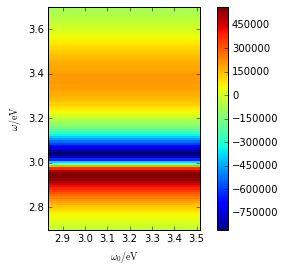

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
plt.imshow(Klist[:,:,2,2].real, extent=(ω_0list.min()*ℏ/eV, ω_0list.max()*ℏ/eV, ωlist.min()*ℏ/eV, ωlist.max()*ℏ/eV),
           interpolation='nearest', #norm=LogNorm(), 
           origin='lower', cmap=cm.jet)
plt.colorbar()
plt.xlabel('$\omega_0/\mathrm{eV}$')
plt.ylabel('$\omega/\mathrm{eV}$')  

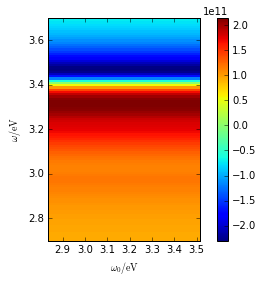

In [7]:
%matplotlib inline
plt.imshow(Kselflist[:,:,0,0].real, extent=(ω_0list.min()*ℏ/eV, ω_0list.max()*ℏ/eV, ωlist.min()*ℏ/eV, ωlist.max()*ℏ/eV),
           interpolation='nearest', #norm=LogNorm(), 
           origin='lower', cmap=cm.jet)
plt.colorbar()
plt.xlabel('$\omega_0/\mathrm{eV}$')
plt.ylabel('$\omega/\mathrm{eV}$')  

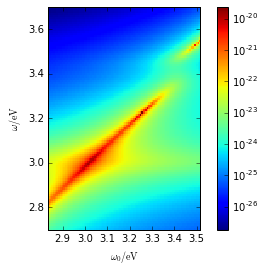

In [8]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LogNorm
%matplotlib inline
plt.imshow(Slist, extent=(ω_0list.min()*ℏ/eV, ω_0list.max()*ℏ/eV, ωlist.min()*ℏ/eV, ωlist.max()*ℏ/eV),
           interpolation='nearest', norm=LogNorm(), origin='lower', cmap=cm.jet)
plt.colorbar()
plt.xlabel('$\omega_0/\mathrm{eV}$')
plt.ylabel('$\omega/\mathrm{eV}$')
#plt.imshow(Slist, extent=(ω_0list.min()*ℏ/eV, ω_0list.max()*ℏ/eV, ωlist.min()*ℏ/eV, ωlist.max()*ℏ/eV),
#           interpolation='nearest', norm=LogNorm(''), 
#           origin='lower', cmap=cm.jet)
#plt.colorbar()
#plt.xlabel('$\omega_0/\mathrm{eV}$')
#plt.ylabel('$\omega/\mathrm{eV}$')  

In [ ]:
# From PRL 112, 253601 (1)
def Grr_Delga(nmax, a, r, k, ε_m, ε_b):
    om = k * c
    z = (r-a)/a
    g0 = om*cmath.sqrt(ε_b)/(6*c*π)
    n = np.arange(1,nmax+1)
    s = np.sum( (n+1)**2 * (ε_m-ε_b) / ((1+z)**(2*n+4) * (ε_m + ((n+1)/n)*ε_b)))
    return (g0 + s * c**2/(4*π*om**2*ε_b*a**3))


nmax=20
a = 7e-9 #7e-9
r1 = np.array([8e-9,0,0]) # atom position 8e-9
ω_p = 9*eV/ℏ #9*eV/ℏ
#print(ω_p)
ε_inf = 4.6
γ_p = 0.1*eV/ℏ
ε_b = 2.13
γ_QE = 0.015*eV/ℏ # Original Delga: 15 meV. Makes the peak too sharp.
μ = np.array([0.19e-9*e,0,0])

R = np.array([0,1e-6,0]) # detector position
startω = 2.7*eV/ℏ
stopω = 3.7*eV/ℏ
ωlist = np.linspace(startω, stopω, 100)
ω_0list = np.linspace(startω*1.05, stopω*0.95, 90)
Slist = np.empty(shape=(ωlist.shape[0],ω_0list.shape[0]),dtype=float)
Klist = np.empty(shape=(ωlist.shape[0],ω_0list.shape[0]),dtype=float)
Kselflist = np.empty(shape=(ωlist.shape[0],ω_0list.shape[0]),dtype=float)
for i in range(ω_0list.shape[0]):
    ω_0 = ω_0list[i]
    Ω = ω_0+1j*γ_QE
    for j in range(ωlist.shape[0]):
        ω = ωlist[j]
        ε_m = ε_drude(ε_inf, ω_p, γ_p, ω)
        k = ω/c
        k_out = math.sqrt(ε_b)*k
        k_in = cmath.sqrt(ε_m)*k
        #print ("ε_m",ε_m)
        K     = G_Mie_scat_cart(source_cart=r1, dest_cart=R,  a=a, nmax=nmax, k_i=k_in, k_e=k_out)
        Kself = G_Mie_scat_cart(source_cart=r1, dest_cart=r1, a=a, nmax=nmax, k_i=k_in, k_e=k_out)
        num = np.linalg.norm((ω*ω/(c*c*ε_0))*np.dot(K,μ))**2
        den = abs(ω*ω-2j*ω*Ω.imag - abs(Ω)**2 
           +2*(ω*ω/(c*c*ε_0*ℏ)) * Ω.real*np.dot(μ,np.dot(Kself,μ)))**2
        Slist[j,i] = num/den*2*(ω*ω+abs(Ω)**2)
        #Slist[k,i] = pref*postf
        

In [51]:
# Draw scattering Green's function
%matplotlib inline
import matplotlib.pyplot as plt

a = 7e-9 #7e-9
r1 = np.array([8e-9,0,0]) # atom position 8e-9
ω_p = 9*eV/ℏ #9*eV/ℏ
#print(ω_p)
ε_inf = 4.6
γ_p = 0.1*eV/ℏ
ε_b = 2.13
γ_QE = 0.015*eV/ℏ # Original Delga: 15 meV. Makes the peak too sharp.
μ = np.array([0.19e-9*e,0,0])

R = np.array([0,1e-8,2e-9]) # detector position
#R = np.array([0,15e-8,0])
ω_0 = 3.30*eV/ℏ
Ω = ω_0+1j*γ_QE
startω = 2.7*eV/ℏ
stopω = 6.0*eV/ℏ
nmax=10

ωlist = np.linspace(startω, stopω, 300)
Glist = np.empty(shape=ωlist.shape+(3,3),dtype=np.complex_)
Gselflist =  np.empty(shape=ωlist.shape+(3,3),dtype=np.complex_)
for i in range(ωlist.shape[0]):
    ω = ωlist[i]
    ε_m = ε_drude(ε_inf, ω_p, γ_p, ω)
    k = ω/c
    k_out = math.sqrt(ε_b)*k
    k_in = cmath.sqrt(ε_m)*k
    #print ("ε_m",ε_m)
    Glist[i] = G_Mie_scat_cart(source_cart=r1, dest_cart=R,  a=a, nmax=nmax, k_i=k_in, k_e=k_out)
    Gselflist[i] = G_Mie_scat_cart(source_cart=r1, dest_cart=r1, a=a, nmax=nmax, k_i=k_in, k_e=k_out)

/home/necadam1/.local/lib/python3.4/site-packages/numpy-1.12.0.dev0+c303c9b-py3.4-linux-x86_64.egg/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


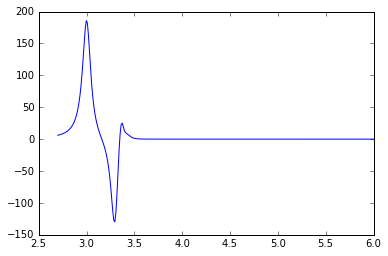

In [95]:
# My own gf
plt.plot(ωlist*ℏ/eV, Glist[:,0,0])

/home/necadam1/.local/lib/python3.4/site-packages/numpy-1.12.0.dev0+c303c9b-py3.4-linux-x86_64.egg/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


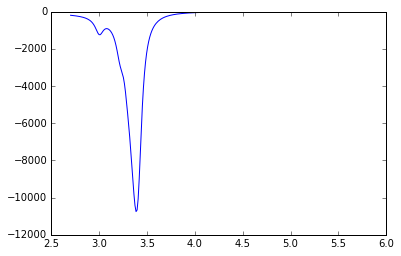

In [96]:
plt.plot(ωlist*ℏ/eV, Gselflist[:,0,0])

In [110]:
#gf from van Vlack
# Draw scattering Green's function
%matplotlib inline
import matplotlib.pyplot as plt

a = 7e-9 #7e-9
r1 = np.array([8e-9,0,0]) # atom position 8e-9
ω_p = 9*eV/ℏ #9*eV/ℏ
#print(ω_p)
ε_inf = 4.6
γ_p = 0.1*eV/ℏ
ε_b = 2.13
γ_QE = 0.015*eV/ℏ # Original Delga: 15 meV. Makes the peak too sharp.
μ = np.array([0.19e-9*e,0,0])

R = np.array([0,1e-8,2e-9]) # detector position
#R = np.array([0,15e-8,0])
ω_0 = 3.30*eV/ℏ
Ω = ω_0+1j*γ_QE
startω = 2.7*eV/ℏ
stopω = 6.0*eV/ℏ
nmax=10

ωlist = np.linspace(startω, stopω, 300)
Glist = np.empty(shape=ωlist.shape+(3,3),dtype=np.complex_)
Gselflist =  np.empty(shape=ωlist.shape+(3,3),dtype=np.complex_)
for i in range(ωlist.shape[0]):
    ω = ωlist[i]
    ε_m = ε_drude(ε_inf, ω_p, γ_p, ω)
    k = ω/c
    k_out = math.sqrt(ε_b)*k
    k_in = cmath.sqrt(ε_m)*k
    #print ("ε_m",ε_m)
    Glist[i] = G_Mie_scat_cart(source_cart=r1, dest_cart=R,  a=a, nmax=nmax, k_i=k_in, k_e=k_out)
    Gselflist[i] = G_Mie_scat_cart(source_cart=r1, dest_cart=r1, a=a, nmax=nmax, k_i=k_in, k_e=k_out)

/home/necadam1/.local/lib/python3.4/site-packages/numpy-1.12.0.dev0+c303c9b-py3.4-linux-x86_64.egg/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


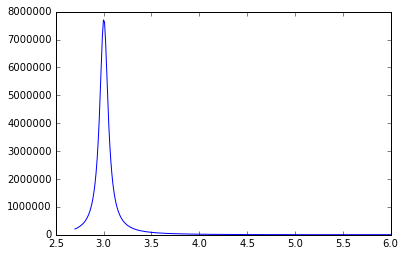

In [111]:
plt.plot(ωlist*ℏ/eV, Glist[:,0,0])

/home/necadam1/.local/lib/python3.4/site-packages/numpy-1.12.0.dev0+c303c9b-py3.4-linux-x86_64.egg/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


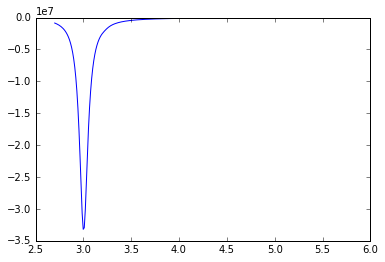

In [112]:
plt.plot(ωlist*ℏ/eV, Gselflist[:,0,0])

In [12]:
# Multiple scattering
nmax=20
a = 7e-9 #7e-9
r1 = np.array([[8e-9,0,0],[8e-9,0,1e-9],[8e-9,1e-9,1e-9],[8e-9,-1e-9,1e-9],[8e-9,1e-9,-1e-9],[8e-9,-1e-9,-1e-9]] ) # atom position 8e-9
ω_p = 9*eV/ℏ #9*eV/ℏ
#print(ω_p)
ε_inf = 4.6
γ_p = 0.1*eV/ℏ
ε_b = 2.13
γ_QE = 0.015*eV/ℏ # Original Delga: 15 meV. Makes the peak too sharp.
μ = np.array([[0.19e-9*e,0,0],[0.19e-9*e,0,0],[0.19e-9*e,0,0],[0.19e-9*e,0,0],[0.19e-9*e,0,0],[0.19e-9*e,0,0],[0.19e-9*e,0,0],[0.19e-9*e,0,0],[0.19e-9*e,0,0],[0.19e-9*e,0,0],[0.19e-9*e,0,0],[0.19e-9*e,0,0],[0.19e-9*e,0,0],[0.19e-9*e,0,0],[0.19e-9*e,0,0],[0.19e-9*e,0,0],])

npart = r1.shape[0]

R = np.array([0,1e-6,0]) # detector position
startω = 2.7*eV/ℏ
stopω = 3.7*eV/ℏ
ωlist = np.linspace(startω, stopω, 100)
ω_0list = np.linspace(startω*1.05, stopω*0.95, 90)
Slist = np.empty(shape=(ωlist.shape[0],ω_0list.shape[0]),dtype=float)
Klist = np.empty(shape=(ωlist.shape[0],ω_0list.shape[0],3,3),dtype=np.complex_)
Kselflist = np.empty(shape=(ωlist.shape[0],ω_0list.shape[0],3,3),dtype=np.complex_)
mKmlist = np.empty(shape=(ωlist.shape[0],ω_0list.shape[0],npart,npart,), dtype=np.complex_)
Km_destlist = np.empty(shape=(ωlist.shape[0],ω_0list.shape[0],npart,3), dtype=np.complex_)
G_sourcelist = np.empty(shape=(ωlist.shape[0],ω_0list.shape[0],npart,3), dtype=np.complex_)
Vlist = np.empty(shape=(ωlist.shape[0],ω_0list.shape[0]),dtype=np.complex_)
for i in range(ω_0list.shape[0]):
    ω_0 = ω_0list[i]
    Ω = ω_0+1j*γ_QE
    for j in range(ωlist.shape[0]):
        ω = ωlist[j]
        V = -(ω*ω/(c*c*ε_0*ℏ))*2*Ω.real/(ω*ω-2j*ω*Ω.imag - abs(Ω)**2)
        Vlist[j,i]=V
        
        ε_m = ε_drude(ε_inf, ω_p, γ_p, ω)
        k = ω/c
        k_out = math.sqrt(ε_b)*k
        k_in = cmath.sqrt(ε_m)*k
        RH, RV, TH, TV = mie_coefficients(a, nmax, k_i=k_in, k_e=k_out, μ_i=1, μ_e=1, J_ext=1, J_scat=3)
        #G_Mie_scat_precalc_cart_new(source_cart, dest_cart, RH, RV, a, nmax, k_i=k_in, k_e=k_out, μ_i=1, μ_e=1, J_ext=1, J_scat=3)
        #print ("ε_m",ε_m)
        mKm = np.empty((npart, npart),dtype=np.complex_) # source-dest order
        Km_dest = np.empty((npart,3),dtype=np.complex_)
        Tself = np.empty((npart,),dtype=np.complex_)
        M = np.empty((npart, npart), dtype=np.complex_)
        for n in range(npart): # n is source index
            Km_dest[n] = np.dot(μ[n], G_Mie_scat_precalc_cart_new(r1[n], R, 
                                                 RH, RV, a, nmax, k_i=k_in, k_e=k_out, μ_i=1, μ_e=1, J_ext=1, J_scat=3) 
                                               + G0_dip_1(R-r1[n],k_out))
            for m in range(npart): # m is dest index
                if(m == n):
                    #fixme pořadí indexů v greenových funkcích je „nepřirozené“
                    mKm[n,m] = np.dot(μ[n], np.dot(G_Mie_scat_precalc_cart_new(r1[n], r1[m], 
                                                 RH, RV, a, nmax, k_i=k_in, k_e=k_out, μ_i=1, μ_e=1, J_ext=1, J_scat=3) 
                                               , μ[m])
                                     )
                else:
                    #print("To ne!")
                    mKm[n,m] = np.dot(μ[n], np.dot(G_Mie_scat_precalc_cart_new(r1[n], r1[m], 
                                                RH, RV, a, nmax, k_i=k_in, k_e=k_out, μ_i=1, μ_e=1, J_ext=1, J_scat=3) 
                                               + G0_dip_1(r1[m]-r1[n],k_out)
                                             , μ[m])
                                     )
            Tself[n] = V/(1-mKm[n,n]*V)
            for m in range(npart):
                if(m==n):
                    M[n,m] = 1
                else:
                    #print("To ne!")
                    M[n,m] = -mKm[n,m]*Tself[n]
        M_inv = np.linalg.inv(M)
        # NB still source dest order. The dipole moments are already included 
        # in mKm, Km_dest, so no need to have them here:
        T = Tself[ň,:]*M_inv[:,:] 
        # Delga supplement, eq.(23): Here we have no free radiation in the initial state.
        # FIXME PROBLÉM TU???
        G_source_n = Km_dest + np.dot(mKm,np.dot(T,Km_dest))
        #print(G_source_n.shape)
        #K     = G_Mie_scat_cart(source_cart=r1, dest_cart=R,  a=a, nmax=nmax, k_i=k_in, k_e=k_out)+G0_dip_1(R-r1,k_out)
        #Klist[j,i]=K
        mKmlist[j,i]=mKm
        Km_destlist[j,i]=Km_dest
        G_sourcelist[j,i]=G_source_n
        #Kself = G_Mie_scat_cart(source_cart=r1, dest_cart=r1, a=a, nmax=nmax, k_i=k_in, k_e=k_out)
        #Kselflist[j,i]=Kself
        # Single QE contribution, eq. (29):
        S_n0 = np.dot(((ω*ω/(c*c*ε_0))*np.linalg.norm(G_source_n, axis=-1))**2 , (
            np.identity(npart)/abs(ω-Ω)**2 + 1/(ω+Ω)**2))
        #den = abs(ω*ω-2j*ω*Ω.imag - abs(Ω)**2 
        #   +2*(ω*ω/(c*c*ε_0*ℏ)) * Ω.real*np.dot(μ,np.dot(Kself,μ)))**2
        Slist[j,i] = np.sum(S_n0)#num/den*2*(ω*ω+abs(Ω)**2)

/home/necadam1/.local/lib/python3.4/site-packages/ipykernel/__main__.py:91: ComplexWarning: Casting complex values to real discards the imaginary part


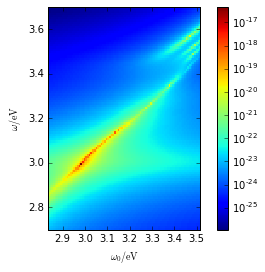

In [13]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LogNorm
%matplotlib inline
plt.imshow(Slist, extent=(ω_0list.min()*ℏ/eV, ω_0list.max()*ℏ/eV, ωlist.min()*ℏ/eV, ωlist.max()*ℏ/eV),
           interpolation='nearest', norm=LogNorm(), origin='lower', cmap=cm.jet)
plt.colorbar()
plt.xlabel('$\omega_0/\mathrm{eV}$')
plt.ylabel('$\omega/\mathrm{eV}$')

(16, 3) (100, 90)


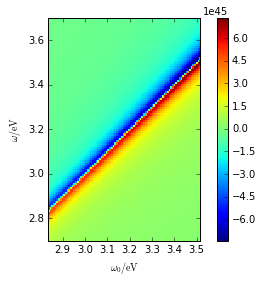

In [19]:
%matplotlib inline
print (μ.shape, Vlist.shape)
#print (np.tensordot(μ,np.tensordot(Km_destlist,μ, axes=([2,],[0,])),axes=([0,],[2,])).real.shape)
plt.imshow(Vlist.real,
           extent=(ω_0list.min()*ℏ/eV, ω_0list.max()*ℏ/eV, ωlist.min()*ℏ/eV, ωlist.max()*ℏ/eV),
           interpolation='nearest', #norm=LogNorm(), 
           origin='lower', cmap=cm.jet)
plt.colorbar()
plt.xlabel('$\omega_0/\mathrm{eV}$')
plt.ylabel('$\omega/\mathrm{eV}$')  

(16, 3) (100, 90, 6, 3)


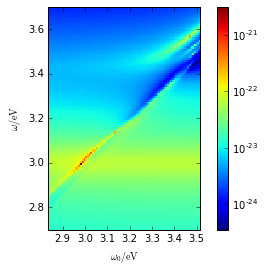

In [22]:
%matplotlib inline
print (μ.shape, G_sourcelist.shape)
#print (np.tensordot(μ,np.tensordot(Km_destlist,μ, axes=([2,],[0,])),axes=([0,],[2,])).real.shape)
plt.imshow(np.linalg.norm(G_sourcelist[:,:,0,:],axis=2),
           extent=(ω_0list.min()*ℏ/eV, ω_0list.max()*ℏ/eV, ωlist.min()*ℏ/eV, ωlist.max()*ℏ/eV),
           interpolation='nearest', norm=LogNorm(), 
           origin='lower', cmap=cm.jet)
plt.colorbar()
plt.xlabel('$\omega_0/\mathrm{eV}$')
plt.ylabel('$\omega/\mathrm{eV}$')  

(16, 3) (100, 90, 6, 3)


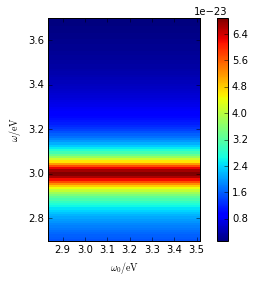

In [21]:
%matplotlib inline
print (μ.shape, Km_destlist.shape)
#print (np.tensordot(μ,np.tensordot(Km_destlist,μ, axes=([2,],[0,])),axes=([0,],[2,])).real.shape)
plt.imshow(np.linalg.norm(Km_destlist[:,:,0,:],axis=2),
           extent=(ω_0list.min()*ℏ/eV, ω_0list.max()*ℏ/eV, ωlist.min()*ℏ/eV, ωlist.max()*ℏ/eV),
           interpolation='nearest', #norm=LogNorm(), 
           origin='lower', cmap=cm.jet)
plt.colorbar()
plt.xlabel('$\omega_0/\mathrm{eV}$')
plt.ylabel('$\omega/\mathrm{eV}$')  

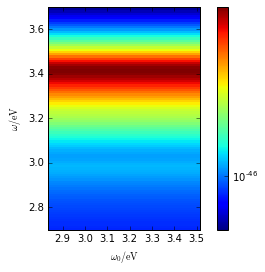

In [17]:
%matplotlib inline
plt.imshow(abs(mKmlist[:,:,0,0]), extent=(ω_0list.min()*ℏ/eV, ω_0list.max()*ℏ/eV, ωlist.min()*ℏ/eV, ωlist.max()*ℏ/eV),
           interpolation='nearest', norm=LogNorm(), 
           origin='lower', cmap=cm.jet)
plt.colorbar()
plt.xlabel('$\omega_0/\mathrm{eV}$')
plt.ylabel('$\omega/\mathrm{eV}$')

(-1e-45, 1e-45)

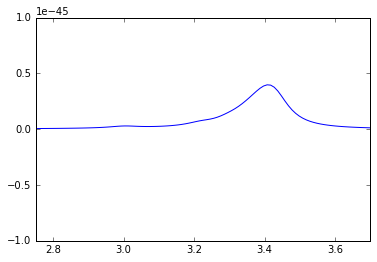

In [18]:
plt.plot(ωlist*ℏ/eV,(mKmlist[:,:,0,0]).imag[:,0])
plt.xlim(2.75,3.7)
plt.ylim(-1e-45,1e-45)

In [229]:

nmax=20
a = 7e-9 #7e-9
r1 = np.array([8e-9,0,0]) # atom position 8e-9
ω_p = 9*eV/ℏ #9*eV/ℏ
#print(ω_p)
ε_inf = 4.6
γ_p = 0.1*eV/ℏ
ε_b = 2.13
γ_QE = 0.015*eV/ℏ # Original Delga: 15 meV. Makes the peak too sharp.
μ = np.array([0.19e-9*e,0,0])

R = np.array([0,1e-6,0]) # detector position
startω = 2.7*eV/ℏ
stopω = 3.7*eV/ℏ
ωlist = np.linspace(startω, stopω, 100)
ω_0list = np.linspace(startω*1.05, stopω*0.95, 90)
Slist = np.empty(shape=(ωlist.shape[0],ω_0list.shape[0]),dtype=float)
Vlist2 = np.empty(shape=(ωlist.shape[0],ω_0list.shape[0]),dtype=np.complex_)
Klist = np.empty(shape=(ωlist.shape[0],ω_0list.shape[0],3,3),dtype=np.complex_)
Kselflist = np.empty(shape=(ωlist.shape[0],ω_0list.shape[0],3,3),dtype=np.complex_)
glist = np.empty(shape=(ωlist.shape[0],ω_0list.shape[0],3,3),dtype=np.complex_)
for i in range(ω_0list.shape[0]):
    ω_0 = ω_0list[i]
    Ω = ω_0+1j*γ_QE
    for j in range(ωlist.shape[0]):
        RH, RV, TH, TV = mie_coefficients(a, nmax, k_i=k_in, k_e=k_out, μ_i=1, μ_e=1, J_ext=1, J_scat=3)
      
        ω = ωlist[j]
        V = -(ω*ω/(c*c*ε_0*ℏ))*2*Ω.real/(ω*ω-2j*ω*Ω.imag - abs(Ω)**2)
        Vlist2[j,i]=V
        ε_m = ε_drude(ε_inf, ω_p, γ_p, ω)
        k = ω/c
        k_out = math.sqrt(ε_b)*k
        k_in = cmath.sqrt(ε_m)*k
        # FIXME WTF why do I get different results from the two variants (the strip on the bottom of the picture)?
        #print ("ε_m",ε_m)
        #K     =  G_Mie_scat_cart(source_cart=r1, dest_cart=R,  a=a, nmax=nmax, k_i=k_in, k_e=k_out)+G0_dip_1(R-r1,k_out)
        K =        G_Mie_scat_precalc_cart_new(r1, R, 
                                                 RH, RV, a, nmax, k_i=k_in, k_e=k_out, μ_i=1, μ_e=1, J_ext=1, J_scat=3) +G0_dip_1(R-r1,k_out)

        Klist[j,i]=K
        #Kself = G_Mie_scat_cart(source_cart=r1, dest_cart=r1, a=a, nmax=nmax, k_i=k_in, k_e=k_out)
        Kself = G_Mie_scat_precalc_cart_new(r1, r1, 
                                                 RH, RV, a, nmax, k_i=k_in, k_e=k_out, μ_i=1, μ_e=1, J_ext=1, J_scat=3) 

        Kselflist[j,i]=Kself

        g = K/(1-np.dot(μ,np.dot(Kself,μ))*V)
        glist[j,i]=g
        Slist[j,i] = np.linalg.norm(ω*ω/(c*c*ε_0)*np.dot(g,μ))**2*(1/abs(ω-Ω)**2 + 1/abs(ω+Ω)**2)
        #num = np.linalg.norm((ω*ω/(c*c*ε_0))*np.dot(K,μ))**2
        #den = abs(ω*ω-2j*ω*Ω.imag - abs(Ω)**2 
        #   +2*(ω*ω/(c*c*ε_0*ℏ)) * Ω.real*np.dot(μ,np.dot(Kself,μ)))**2
        #Slist[j,i] = num/den*2*(ω*ω+abs(Ω)**2)
        #Slist[k,i] = pref*postf

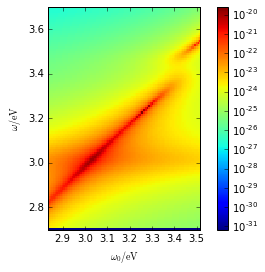

In [230]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LogNorm
%matplotlib inline
plt.imshow(Slist, extent=(ω_0list.min()*ℏ/eV, ω_0list.max()*ℏ/eV, ωlist.min()*ℏ/eV, ωlist.max()*ℏ/eV),
           interpolation='nearest', norm=LogNorm(), origin='lower', cmap=cm.jet)
plt.colorbar()
plt.xlabel('$\omega_0/\mathrm{eV}$')
plt.ylabel('$\omega/\mathrm{eV}$')

(3,) (100, 90, 3, 3)


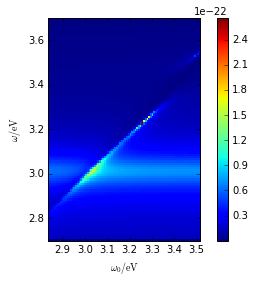

In [216]:
%matplotlib inline
print (μ.shape, glist.shape)
#print (np.dot(μ,glist).shape)
plt.imshow(np.linalg.norm(np.dot(μ,glist),axis=2),
           extent=(ω_0list.min()*ℏ/eV, ω_0list.max()*ℏ/eV, ωlist.min()*ℏ/eV, ωlist.max()*ℏ/eV),
           interpolation='nearest', #norm=LogNorm(), 
           origin='lower', cmap=cm.jet)
plt.colorbar()
plt.xlabel('$\omega_0/\mathrm{eV}$')
plt.ylabel('$\omega/\mathrm{eV}$')  

(3,) (100, 90, 3, 3)
(100, 90, 3)


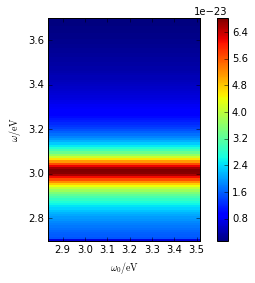

In [196]:
%matplotlib inline
print (μ.shape, Klist.shape)
print (np.dot(μ,Klist).shape)
plt.imshow(np.linalg.norm(np.dot(μ,Klist),axis=2),
           extent=(ω_0list.min()*ℏ/eV, ω_0list.max()*ℏ/eV, ωlist.min()*ℏ/eV, ωlist.max()*ℏ/eV),
           interpolation='nearest', #norm=LogNorm(), 
           origin='lower', cmap=cm.jet)
plt.colorbar()
plt.xlabel('$\omega_0/\mathrm{eV}$')
plt.ylabel('$\omega/\mathrm{eV}$')  

(3,) (100, 90, 3, 3)
(100, 90)


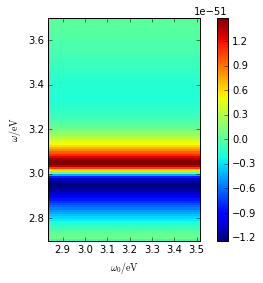

In [197]:
%matplotlib inline
print (μ.shape, Klist.shape)
print (np.tensordot(μ,np.tensordot(Klist,μ, axes=([2,],[0,])),axes=([0,],[2,])).real.shape)
plt.imshow(np.tensordot(μ,np.tensordot(Klist,μ, axes=([2,],[0,])),axes=([0,],[2,])).real,
           extent=(ω_0list.min()*ℏ/eV, ω_0list.max()*ℏ/eV, ωlist.min()*ℏ/eV, ωlist.max()*ℏ/eV),
           interpolation='nearest', #norm=LogNorm(), 
           origin='lower', cmap=cm.jet)
plt.colorbar()
plt.xlabel('$\omega_0/\mathrm{eV}$')
plt.ylabel('$\omega/\mathrm{eV}$')  

(3,) (100, 90, 3, 3)
(100, 90)


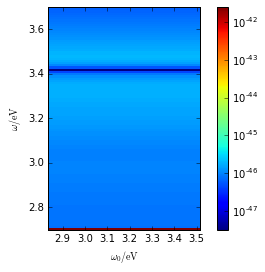

In [206]:
%matplotlib inline
print (μ.shape, Kselflist.shape)
print (np.tensordot(μ,np.tensordot(Kselflist,μ, axes=([2,],[0,])),axes=([0,],[2,])).real.shape)
plt.imshow(abs(np.tensordot(μ,np.tensordot(Kselflist,μ, axes=([2,],[0,])),axes=([0,],[2,])).real),
           extent=(ω_0list.min()*ℏ/eV, ω_0list.max()*ℏ/eV, ωlist.min()*ℏ/eV, ωlist.max()*ℏ/eV),
           interpolation='nearest', norm=LogNorm(), 
           origin='lower', cmap=cm.jet)
plt.colorbar()
plt.xlabel('$\omega_0/\mathrm{eV}$')
plt.ylabel('$\omega/\mathrm{eV}$')  

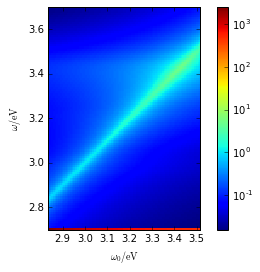

In [217]:
%matplotlib inline
plt.imshow(abs(Vlist2*np.tensordot(μ,np.tensordot(Kselflist,μ, axes=([2,],[0,])),axes=([0,],[2,]))),
           extent=(ω_0list.min()*ℏ/eV, ω_0list.max()*ℏ/eV, ωlist.min()*ℏ/eV, ωlist.max()*ℏ/eV),
           interpolation='nearest', norm=LogNorm(), 
           origin='lower', cmap=cm.jet)
plt.colorbar()
plt.xlabel('$\omega_0/\mathrm{eV}$')
plt.ylabel('$\omega/\mathrm{eV}$')  

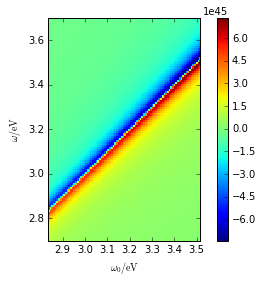

In [218]:
%matplotlib inline
plt.imshow(Vlist2.real,
           extent=(ω_0list.min()*ℏ/eV, ω_0list.max()*ℏ/eV, ωlist.min()*ℏ/eV, ωlist.max()*ℏ/eV),
           interpolation='nearest', #norm=LogNorm(), 
           origin='lower', cmap=cm.jet)
plt.colorbar()
plt.xlabel('$\omega_0/\mathrm{eV}$')
plt.ylabel('$\omega/\mathrm{eV}$')  

(-1e-45, 1e-45)

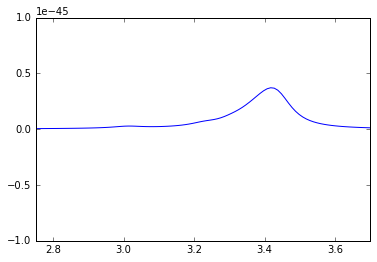

In [164]:
plt.plot(ωlist*ℏ/eV,(np.tensordot(μ,np.tensordot(Kselflist,μ, axes=([2,],[0,])),axes=([0,],[2,]))[:,0]).imag)
plt.xlim(2.75,3.7)
plt.ylim(-1e-45,1e-45)

In [138]:
np.tensordot(μ,np.tensordot(Kselflist,μ, axes=([2,],[0,])),axes=([0,],[2,])).shape

(100, 90)

In [128]:
T

array([[ -6.71786111e+43 -2.31959639e+41j]])

In [23]:
# Multiple scattering
nmax=20
a = 7e-9 #7e-9
r1 = np.array([[-8e-9,0,0],[-8e-9,0,1e-9],[-8e-9,1e-9,1e-9],[8e-9,-1e-9,1e-9],[8e-9,1e-9,-1e-9],[8e-9,-1e-9,-1e-9]] ) # atom position 8e-9
ω_p = 9*eV/ℏ #9*eV/ℏ
#print(ω_p)
ε_inf = 4.6
γ_p = 0.1*eV/ℏ
ε_b = 2.13
γ_QE = 0.015*eV/ℏ # Original Delga: 15 meV. Makes the peak too sharp.
μ = np.array([[0.19e-9*e,0,0],[0.19e-9*e,0,0],[0.19e-9*e,0,0],[0.19e-9*e,0,0],[0.19e-9*e,0,0],[0.19e-9*e,0,0],[0.19e-9*e,0,0],[0.19e-9*e,0,0],[0.19e-9*e,0,0],[0.19e-9*e,0,0],[0.19e-9*e,0,0],[0.19e-9*e,0,0],[0.19e-9*e,0,0],[0.19e-9*e,0,0],[0.19e-9*e,0,0],[0.19e-9*e,0,0],])

npart = r1.shape[0]

R = np.array([0,1e-6,0]) # detector position
startω = 2.7*eV/ℏ
stopω = 3.7*eV/ℏ
ωlist = np.linspace(startω, stopω, 100)
ω_0list = np.linspace(startω*1.05, stopω*0.95, 90)
Slist = np.empty(shape=(ωlist.shape[0],ω_0list.shape[0]),dtype=float)
Klist = np.empty(shape=(ωlist.shape[0],ω_0list.shape[0],3,3),dtype=np.complex_)
Kselflist = np.empty(shape=(ωlist.shape[0],ω_0list.shape[0],3,3),dtype=np.complex_)
mKmlist = np.empty(shape=(ωlist.shape[0],ω_0list.shape[0],npart,npart,), dtype=np.complex_)
Km_destlist = np.empty(shape=(ωlist.shape[0],ω_0list.shape[0],npart,3), dtype=np.complex_)
G_sourcelist = np.empty(shape=(ωlist.shape[0],ω_0list.shape[0],npart,3), dtype=np.complex_)
Vlist = np.empty(shape=(ωlist.shape[0],ω_0list.shape[0]),dtype=np.complex_)
for i in range(ω_0list.shape[0]):
    ω_0 = ω_0list[i]
    Ω = ω_0+1j*γ_QE
    for j in range(ωlist.shape[0]):
        ω = ωlist[j]
        V = -(ω*ω/(c*c*ε_0*ℏ))*2*Ω.real/(ω*ω-2j*ω*Ω.imag - abs(Ω)**2)
        Vlist[j,i]=V
        
        ε_m = ε_drude(ε_inf, ω_p, γ_p, ω)
        k = ω/c
        k_out = math.sqrt(ε_b)*k
        k_in = cmath.sqrt(ε_m)*k
        RH, RV, TH, TV = mie_coefficients(a, nmax, k_i=k_in, k_e=k_out, μ_i=1, μ_e=1, J_ext=1, J_scat=3)
        #G_Mie_scat_precalc_cart_new(source_cart, dest_cart, RH, RV, a, nmax, k_i=k_in, k_e=k_out, μ_i=1, μ_e=1, J_ext=1, J_scat=3)
        #print ("ε_m",ε_m)
        mKm = np.empty((npart, npart),dtype=np.complex_) # source-dest order
        Km_dest = np.empty((npart,3),dtype=np.complex_)
        Tself = np.empty((npart,),dtype=np.complex_)
        M = np.empty((npart, npart), dtype=np.complex_)
        for n in range(npart): # n is source index
            Km_dest[n] = np.dot(μ[n], G_Mie_scat_precalc_cart_new(r1[n], R, 
                                                 RH, RV, a, nmax, k_i=k_in, k_e=k_out, μ_i=1, μ_e=1, J_ext=1, J_scat=3) 
                                               + G0_dip_1(R-r1[n],k_out))
            for m in range(npart): # m is dest index
                if(m == n):
                    #fixme pořadí indexů v greenových funkcích je „nepřirozené“
                    mKm[n,m] = np.dot(μ[n], np.dot(G_Mie_scat_precalc_cart_new(r1[n], r1[m], 
                                                 RH, RV, a, nmax, k_i=k_in, k_e=k_out, μ_i=1, μ_e=1, J_ext=1, J_scat=3) 
                                               , μ[m])
                                     )
                else:
                    #print("To ne!")
                    mKm[n,m] = np.dot(μ[n], np.dot(G_Mie_scat_precalc_cart_new(r1[n], r1[m], 
                                                RH, RV, a, nmax, k_i=k_in, k_e=k_out, μ_i=1, μ_e=1, J_ext=1, J_scat=3) 
                                               + G0_dip_1(r1[m]-r1[n],k_out)
                                             , μ[m])
                                     )
            Tself[n] = V/(1-mKm[n,n]*V)
            for m in range(npart):
                if(m==n):
                    M[n,m] = 1
                else:
                    #print("To ne!")
                    M[n,m] = -mKm[n,m]*Tself[n]
        M_inv = np.linalg.inv(M)
        # NB still source dest order. The dipole moments are already included 
        # in mKm, Km_dest, so no need to have them here:
        T = Tself[ň,:]*M_inv[:,:] 
        # Delga supplement, eq.(23): Here we have no free radiation in the initial state.
        # FIXME PROBLÉM TU???
        G_source_n = Km_dest + np.dot(mKm,np.dot(T,Km_dest))
        #print(G_source_n.shape)
        #K     = G_Mie_scat_cart(source_cart=r1, dest_cart=R,  a=a, nmax=nmax, k_i=k_in, k_e=k_out)+G0_dip_1(R-r1,k_out)
        #Klist[j,i]=K
        mKmlist[j,i]=mKm
        Km_destlist[j,i]=Km_dest
        G_sourcelist[j,i]=G_source_n
        #Kself = G_Mie_scat_cart(source_cart=r1, dest_cart=r1, a=a, nmax=nmax, k_i=k_in, k_e=k_out)
        #Kselflist[j,i]=Kself
        # Single QE contribution, eq. (29):
        S_n0 = np.dot(((ω*ω/(c*c*ε_0))*np.linalg.norm(G_source_n, axis=-1))**2 , (
            np.identity(npart)/abs(ω-Ω)**2 + 1/(ω+Ω)**2))
        #den = abs(ω*ω-2j*ω*Ω.imag - abs(Ω)**2 
        #   +2*(ω*ω/(c*c*ε_0*ℏ)) * Ω.real*np.dot(μ,np.dot(Kself,μ)))**2
        Slist[j,i] = np.sum(S_n0)#num/den*2*(ω*ω+abs(Ω)**2)

/home/necadam1/.local/lib/python3.4/site-packages/ipykernel/__main__.py:91: ComplexWarning: Casting complex values to real discards the imaginary part


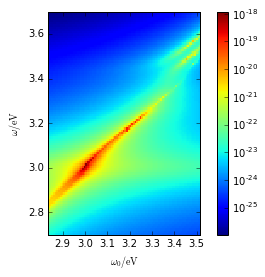

In [24]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LogNorm
%matplotlib inline
plt.imshow(Slist, extent=(ω_0list.min()*ℏ/eV, ω_0list.max()*ℏ/eV, ωlist.min()*ℏ/eV, ωlist.max()*ℏ/eV),
           interpolation='nearest', norm=LogNorm(), origin='lower', cmap=cm.jet)
plt.colorbar()
plt.xlabel('$\omega_0/\mathrm{eV}$')
plt.ylabel('$\omega/\mathrm{eV}$')

(16, 3) (100, 90, 6, 3)


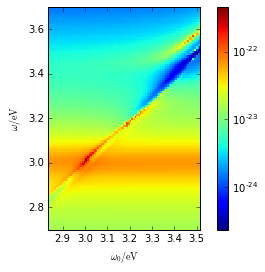

In [25]:
%matplotlib inline
print (μ.shape, G_sourcelist.shape)
#print (np.tensordot(μ,np.tensordot(Km_destlist,μ, axes=([2,],[0,])),axes=([0,],[2,])).real.shape)
plt.imshow(np.linalg.norm(G_sourcelist[:,:,0,:],axis=2),
           extent=(ω_0list.min()*ℏ/eV, ω_0list.max()*ℏ/eV, ωlist.min()*ℏ/eV, ωlist.max()*ℏ/eV),
           interpolation='nearest', norm=LogNorm(), 
           origin='lower', cmap=cm.jet)
plt.colorbar()
plt.xlabel('$\omega_0/\mathrm{eV}$')
plt.ylabel('$\omega/\mathrm{eV}$')  

In [53]:
# Multiple scattering
nmax=20
a = 7e-9 #7e-9
#r1 = np.array([[-8e-9,0,0],[-8e-9,0,1e-9],[-8e-9,1e-9,1e-9],[8e-9,-1e-9,1e-9],[8e-9,1e-9,-1e-9],[8e-9,-1e-9,-1e-9]] ) # atom position 8e-9
ω_p = 9*eV/ℏ #9*eV/ℏ
#print(ω_p)
ε_inf = 4.6
γ_p = 0.1*eV/ℏ
ε_b = 2.13
npart=20
r1=sph2cart(np.array([[8e-9,π/2.,2*π*fi/npart] for fi in range(npart)]))
#npart = r1.shape[0]

γ_QE = 0.015*eV/ℏ # Original Delga: 15 meV. Makes the peak too sharp.
μ = np.array(npart*[[0.38e-9*e,0,0]])
R = np.array([0,1e-6,0]) # detector position
startω = 2.7*eV/ℏ
stopω = 3.7*eV/ℏ
ωlist = np.linspace(startω, stopω, 100)
ω_0list = np.linspace(startω*1.05, stopω*0.95, 90)
Slist = np.empty(shape=(ωlist.shape[0],ω_0list.shape[0]),dtype=float)
Klist = np.empty(shape=(ωlist.shape[0],ω_0list.shape[0],3,3),dtype=np.complex_)
Kselflist = np.empty(shape=(ωlist.shape[0],ω_0list.shape[0],3,3),dtype=np.complex_)
mKmlist = np.empty(shape=(ωlist.shape[0],ω_0list.shape[0],npart,npart,), dtype=np.complex_)
Km_destlist = np.empty(shape=(ωlist.shape[0],ω_0list.shape[0],npart,3), dtype=np.complex_)
G_sourcelist = np.empty(shape=(ωlist.shape[0],ω_0list.shape[0],npart,3), dtype=np.complex_)
Vlist = np.empty(shape=(ωlist.shape[0],ω_0list.shape[0]),dtype=np.complex_)
for i in range(ω_0list.shape[0]):
    ω_0 = ω_0list[i]
    Ω = ω_0+1j*γ_QE
    for j in range(ωlist.shape[0]):
        ω = ωlist[j]
        V = -(ω*ω/(c*c*ε_0*ℏ))*2*Ω.real/(ω*ω-2j*ω*Ω.imag - abs(Ω)**2)
        Vlist[j,i]=V
        
        ε_m = ε_drude(ε_inf, ω_p, γ_p, ω)
        k = ω/c
        k_out = math.sqrt(ε_b)*k
        k_in = cmath.sqrt(ε_m)*k
        RH, RV, TH, TV = mie_coefficients(a, nmax, k_i=k_in, k_e=k_out, μ_i=1, μ_e=1, J_ext=1, J_scat=3)
        #G_Mie_scat_precalc_cart_new(source_cart, dest_cart, RH, RV, a, nmax, k_i=k_in, k_e=k_out, μ_i=1, μ_e=1, J_ext=1, J_scat=3)
        #print ("ε_m",ε_m)
        mKm = np.empty((npart, npart),dtype=np.complex_) # source-dest order
        Km_dest = np.empty((npart,3),dtype=np.complex_)
        Tself = np.empty((npart,),dtype=np.complex_)
        M = np.empty((npart, npart), dtype=np.complex_)
        for n in range(npart): # n is source index
            #print(n,μ[n].shape, r1[n].shape, R.shape)
            Km_dest[n] = np.dot(μ[n], G_Mie_scat_precalc_cart_new(r1[n], R, 
                                                 RH, RV, a, nmax, k_i=k_in, k_e=k_out, μ_i=1, μ_e=1, J_ext=1, J_scat=3) 
                                               + G0_dip_1(R-r1[n],k_out))
            for m in range(npart): # m is dest index
                if(m == n):
                    #fixme pořadí indexů v greenových funkcích je „nepřirozené“
                    mKm[n,m] = np.dot(μ[n], np.dot(G_Mie_scat_precalc_cart_new(r1[n], r1[m], 
                                                 RH, RV, a, nmax, k_i=k_in, k_e=k_out, μ_i=1, μ_e=1, J_ext=1, J_scat=3) 
                                               , μ[m])
                                     )
                else:
                    #print("To ne!")
                    mKm[n,m] = np.dot(μ[n], np.dot(G_Mie_scat_precalc_cart_new(r1[n], r1[m], 
                                                RH, RV, a, nmax, k_i=k_in, k_e=k_out, μ_i=1, μ_e=1, J_ext=1, J_scat=3) 
                                               + G0_dip_1(r1[m]-r1[n],k_out)
                                             , μ[m])
                                     )
            Tself[n] = V/(1-mKm[n,n]*V)
            for m in range(npart):
                if(m==n):
                    M[n,m] = 1
                else:
                    #print("To ne!")
                    M[n,m] = -mKm[n,m]*Tself[n]
        M_inv = np.linalg.inv(M)
        # NB still source dest order. The dipole moments are already included 
        # in mKm, Km_dest, so no need to have them here:
        T = Tself[ň,:]*M_inv[:,:] 
        # Delga supplement, eq.(23): Here we have no free radiation in the initial state.
        # FIXME PROBLÉM TU???
        G_source_n = Km_dest + np.dot(mKm,np.dot(T,Km_dest))
        #print(G_source_n.shape)
        #K     = G_Mie_scat_cart(source_cart=r1, dest_cart=R,  a=a, nmax=nmax, k_i=k_in, k_e=k_out)+G0_dip_1(R-r1,k_out)
        #Klist[j,i]=K
        #mKmlist[j,i]=mKm
        #Km_destlist[j,i]=Km_dest
        #G_sourcelist[j,i]=G_source_n
        #Kself = G_Mie_scat_cart(source_cart=r1, dest_cart=r1, a=a, nmax=nmax, k_i=k_in, k_e=k_out)
        #Kselflist[j,i]=Kself
        # Single QE contribution, eq. (29):
        S_n0 = np.dot(((ω*ω/(c*c*ε_0))*np.linalg.norm(G_source_n, axis=-1))**2 , (
            np.identity(npart)/abs(ω-Ω)**2 + 1/(ω+Ω)**2))
        #den = abs(ω*ω-2j*ω*Ω.imag - abs(Ω)**2 
        #   +2*(ω*ω/(c*c*ε_0*ℏ)) * Ω.real*np.dot(μ,np.dot(Kself,μ)))**2
        Slist[j,i] = np.sum(S_n0)#num/den*2*(ω*ω+abs(Ω)**2)

/home/necadam1/.local/lib/python3.4/site-packages/ipykernel/__main__.py:93: ComplexWarning: Casting complex values to real discards the imaginary part


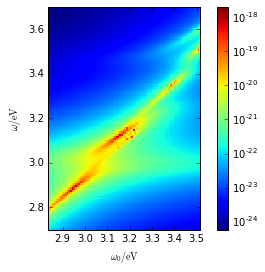

In [56]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LogNorm
%matplotlib inline
plt.imshow(Slist, extent=(ω_0list.min()*ℏ/eV, ω_0list.max()*ℏ/eV, ωlist.min()*ℏ/eV, ωlist.max()*ℏ/eV),
           interpolation='nearest', norm=LogNorm(), origin='lower', cmap=cm.jet
          )
plt.colorbar()
plt.xlabel('$\omega_0/\mathrm{eV}$')
plt.ylabel('$\omega/\mathrm{eV}$')

In [27]:
npart=20
r1=sph2cart(np.array([[8e-9,π/2.,2*π*fi/npart] for fi in range(npart)]))

In [28]:
r1

array([[  8.00000000e-09,   0.00000000e+00,   4.89858720e-25],
       [  7.60845213e-09,   2.47213595e-09,   4.89858720e-25],
       [  6.47213595e-09,   4.70228202e-09,   4.89858720e-25],
       [  4.70228202e-09,   6.47213595e-09,   4.89858720e-25],
       [  2.47213595e-09,   7.60845213e-09,   4.89858720e-25],
       [  4.89858720e-25,   8.00000000e-09,   4.89858720e-25],
       [ -2.47213595e-09,   7.60845213e-09,   4.89858720e-25],
       [ -4.70228202e-09,   6.47213595e-09,   4.89858720e-25],
       [ -6.47213595e-09,   4.70228202e-09,   4.89858720e-25],
       [ -7.60845213e-09,   2.47213595e-09,   4.89858720e-25],
       [ -8.00000000e-09,   9.79717439e-25,   4.89858720e-25],
       [ -7.60845213e-09,  -2.47213595e-09,   4.89858720e-25],
       [ -6.47213595e-09,  -4.70228202e-09,   4.89858720e-25],
       [ -4.70228202e-09,  -6.47213595e-09,   4.89858720e-25],
       [ -2.47213595e-09,  -7.60845213e-09,   4.89858720e-25],
       [ -1.46957616e-24,  -8.00000000e-09,   4.8985872

In [30]:
r1[2]

array([  6.47213595e-09,   4.70228202e-09,   4.89858720e-25])

In [35]:
 np.array(npart*[[0.38e-9*e,0,0]])[0]

array([  6.08827116e-29,   0.00000000e+00,   0.00000000e+00])

In [36]:
μ[n].shape

(20, 3)

In [37]:
n

0

In [40]:
μ

(array([[  6.08827116e-29,   0.00000000e+00,   0.00000000e+00],
        [  6.08827116e-29,   0.00000000e+00,   0.00000000e+00],
        [  6.08827116e-29,   0.00000000e+00,   0.00000000e+00],
        [  6.08827116e-29,   0.00000000e+00,   0.00000000e+00],
        [  6.08827116e-29,   0.00000000e+00,   0.00000000e+00],
        [  6.08827116e-29,   0.00000000e+00,   0.00000000e+00],
        [  6.08827116e-29,   0.00000000e+00,   0.00000000e+00],
        [  6.08827116e-29,   0.00000000e+00,   0.00000000e+00],
        [  6.08827116e-29,   0.00000000e+00,   0.00000000e+00],
        [  6.08827116e-29,   0.00000000e+00,   0.00000000e+00],
        [  6.08827116e-29,   0.00000000e+00,   0.00000000e+00],
        [  6.08827116e-29,   0.00000000e+00,   0.00000000e+00],
        [  6.08827116e-29,   0.00000000e+00,   0.00000000e+00],
        [  6.08827116e-29,   0.00000000e+00,   0.00000000e+00],
        [  6.08827116e-29,   0.00000000e+00,   0.00000000e+00],
        [  6.08827116e-29,   0.00000000e

In [44]:
Slist

array([[  1.37375820e-21,   1.38038817e-21,   1.38706658e-21,
          1.39379390e-21,   1.40057060e-21,   1.40739717e-21,
          1.41427411e-21,   1.42120191e-21,   1.42818107e-21,
          1.43521211e-21,   1.44229553e-21,   1.44943187e-21,
          1.45662165e-21,   1.46386540e-21,   1.47116368e-21,
          1.47851703e-21,   1.48592600e-21,   1.49339116e-21,
          1.50091308e-21,   1.50849233e-21,   1.51612951e-21,
          1.52382521e-21,   1.53158001e-21,   1.53939455e-21,
          1.54726942e-21,   1.55520525e-21,   1.56320267e-21],
       [  2.28338935e-21,   2.29648892e-21,   2.30970187e-21,
          2.32302950e-21,   2.33647315e-21,   2.35003417e-21,
          2.36371391e-21,   2.37751378e-21,   2.39143517e-21,
          2.40547953e-21,   2.41964829e-21,   2.43394293e-21,
          2.44836494e-21,   2.46291584e-21,   2.47759717e-21,
          2.49241048e-21,   2.50735737e-21,   2.52243943e-21,
          2.53765831e-21,   2.55301566e-21,   2.56851316e-21,
       

In [ ]:
# Multiple scattering
nmax=20
a = 20e-9 #7e-9
r1 =np.array([[-21e-9,-4.5e-9+i*3e-9,-4.5e-9+j*3e-9] for i in range(4) for j in range(4)])
ω_p = 9*eV/ℏ #9*eV/ℏ
#print(ω_p)
ε_inf = 4.6
γ_p = 0.1*eV/ℏ
ε_b = 2.13
#npart=20
#r1=sph2cart(np.array([[21e-9,π/2.,2*π*fi/npart] for fi in range(npart)]))
npart = r1.shape[0]

γ_QE = 0.015*eV/ℏ # Original Delga: 15 meV. Makes the peak too sharp.
μ = np.array(npart*[[0.38e-9*e,0,0]])
R = np.array([0,1e-6,0]) # detector position
startω = 2.7*eV/ℏ
stopω = 3.7*eV/ℏ
ωlist = np.linspace(startω, stopω, 100)
ω_0list = np.linspace(startω*1.05, stopω*0.95, 90)
Slist = np.empty(shape=(ωlist.shape[0],ω_0list.shape[0]),dtype=float)
Klist = np.empty(shape=(ωlist.shape[0],ω_0list.shape[0],3,3),dtype=np.complex_)
Kselflist = np.empty(shape=(ωlist.shape[0],ω_0list.shape[0],3,3),dtype=np.complex_)
mKmlist = np.empty(shape=(ωlist.shape[0],ω_0list.shape[0],npart,npart,), dtype=np.complex_)
Km_destlist = np.empty(shape=(ωlist.shape[0],ω_0list.shape[0],npart,3), dtype=np.complex_)
G_sourcelist = np.empty(shape=(ωlist.shape[0],ω_0list.shape[0],npart,3), dtype=np.complex_)
Vlist = np.empty(shape=(ωlist.shape[0],ω_0list.shape[0]),dtype=np.complex_)
for i in range(ω_0list.shape[0]):
    ω_0 = ω_0list[i]
    Ω = ω_0+1j*γ_QE
    for j in range(ωlist.shape[0]):
        ω = ωlist[j]
        V = -(ω*ω/(c*c*ε_0*ℏ))*2*Ω.real/(ω*ω-2j*ω*Ω.imag - abs(Ω)**2)
        Vlist[j,i]=V
        
        ε_m = ε_drude(ε_inf, ω_p, γ_p, ω)
        k = ω/c
        k_out = math.sqrt(ε_b)*k
        k_in = cmath.sqrt(ε_m)*k
        RH, RV, TH, TV = mie_coefficients(a, nmax, k_i=k_in, k_e=k_out, μ_i=1, μ_e=1, J_ext=1, J_scat=3)
        #G_Mie_scat_precalc_cart_new(source_cart, dest_cart, RH, RV, a, nmax, k_i=k_in, k_e=k_out, μ_i=1, μ_e=1, J_ext=1, J_scat=3)
        #print ("ε_m",ε_m)
        mKm = np.empty((npart, npart),dtype=np.complex_) # source-dest order
        Km_dest = np.empty((npart,3),dtype=np.complex_)
        Tself = np.empty((npart,),dtype=np.complex_)
        M = np.empty((npart, npart), dtype=np.complex_)
        for n in range(npart): # n is source index
            #print(n,μ[n].shape, r1[n].shape, R.shape)
            Km_dest[n] = np.dot(μ[n], G_Mie_scat_precalc_cart_new(r1[n], R, 
                                                 RH, RV, a, nmax, k_i=k_in, k_e=k_out, μ_i=1, μ_e=1, J_ext=1, J_scat=3) 
                                               + G0_dip_1(R-r1[n],k_out))
            for m in range(npart): # m is dest index
                if(m == n):
                    #fixme pořadí indexů v greenových funkcích je „nepřirozené“
                    mKm[n,m] = np.dot(μ[n], np.dot(G_Mie_scat_precalc_cart_new(r1[n], r1[m], 
                                                 RH, RV, a, nmax, k_i=k_in, k_e=k_out, μ_i=1, μ_e=1, J_ext=1, J_scat=3) 
                                               , μ[m])
                                     )
                else:
                    #print("To ne!")
                    mKm[n,m] = np.dot(μ[n], np.dot(G_Mie_scat_precalc_cart_new(r1[n], r1[m], 
                                                RH, RV, a, nmax, k_i=k_in, k_e=k_out, μ_i=1, μ_e=1, J_ext=1, J_scat=3) 
                                               + G0_dip_1(r1[m]-r1[n],k_out)
                                             , μ[m])
                                     )
            Tself[n] = V/(1-mKm[n,n]*V)
            for m in range(npart):
                if(m==n):
                    M[n,m] = 1
                else:
                    #print("To ne!")
                    M[n,m] = -mKm[n,m]*Tself[n]
        M_inv = np.linalg.inv(M)
        # NB still source dest order. The dipole moments are already included 
        # in mKm, Km_dest, so no need to have them here:
        T = Tself[ň,:]*M_inv[:,:] 
        # Delga supplement, eq.(23): Here we have no free radiation in the initial state.
        # FIXME PROBLÉM TU???
        G_source_n = Km_dest + np.dot(mKm,np.dot(T,Km_dest))
        #print(G_source_n.shape)
        #K     = G_Mie_scat_cart(source_cart=r1, dest_cart=R,  a=a, nmax=nmax, k_i=k_in, k_e=k_out)+G0_dip_1(R-r1,k_out)
        #Klist[j,i]=K
        #mKmlist[j,i]=mKm
        #Km_destlist[j,i]=Km_dest
        #G_sourcelist[j,i]=G_source_n
        #Kself = G_Mie_scat_cart(source_cart=r1, dest_cart=r1, a=a, nmax=nmax, k_i=k_in, k_e=k_out)
        #Kselflist[j,i]=Kself
        # Single QE contribution, eq. (29):
        S_n0 = np.dot(((ω*ω/(c*c*ε_0))*np.linalg.norm(G_source_n, axis=-1))**2 , (
            np.identity(npart)/abs(ω-Ω)**2 + 1/(ω+Ω)**2))
        #den = abs(ω*ω-2j*ω*Ω.imag - abs(Ω)**2 
        #   +2*(ω*ω/(c*c*ε_0*ℏ)) * Ω.real*np.dot(μ,np.dot(Kself,μ)))**2
        Slist[j,i] = np.sum(S_n0)#num/den*2*(ω*ω+abs(Ω)**2)

In [58]:
np.array([[-21e-9,-4.5e-9+i*3e-9,-4.5e-9+j*3e-9] for i in range(4) for j in range(4)])

array([[ -2.10000000e-08,  -4.50000000e-09,  -4.50000000e-09],
       [ -2.10000000e-08,  -4.50000000e-09,  -1.50000000e-09],
       [ -2.10000000e-08,  -4.50000000e-09,   1.50000000e-09],
       [ -2.10000000e-08,  -4.50000000e-09,   4.50000000e-09],
       [ -2.10000000e-08,  -1.50000000e-09,  -4.50000000e-09],
       [ -2.10000000e-08,  -1.50000000e-09,  -1.50000000e-09],
       [ -2.10000000e-08,  -1.50000000e-09,   1.50000000e-09],
       [ -2.10000000e-08,  -1.50000000e-09,   4.50000000e-09],
       [ -2.10000000e-08,   1.50000000e-09,  -4.50000000e-09],
       [ -2.10000000e-08,   1.50000000e-09,  -1.50000000e-09],
       [ -2.10000000e-08,   1.50000000e-09,   1.50000000e-09],
       [ -2.10000000e-08,   1.50000000e-09,   4.50000000e-09],
       [ -2.10000000e-08,   4.50000000e-09,  -4.50000000e-09],
       [ -2.10000000e-08,   4.50000000e-09,  -1.50000000e-09],
       [ -2.10000000e-08,   4.50000000e-09,   1.50000000e-09],
       [ -2.10000000e-08,   4.50000000e-09,   4.5000000

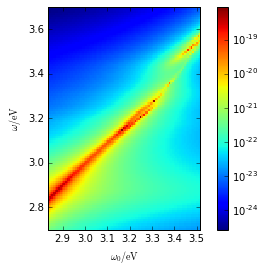

In [60]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LogNorm
%matplotlib inline
plt.imshow(Slist, extent=(ω_0list.min()*ℏ/eV, ω_0list.max()*ℏ/eV, ωlist.min()*ℏ/eV, ωlist.max()*ℏ/eV),
           interpolation='nearest', norm=LogNorm(), origin='lower', cmap=cm.jet
          )
plt.colorbar()
plt.xlabel('$\omega_0/\mathrm{eV}$')
plt.ylabel('$\omega/\mathrm{eV}$')

In [61]:
# Multiple scattering
nmax=40
a = 20e-9 #7e-9
r1 =np.array([[-21e-9,-4.5e-9+i*3e-9,-4.5e-9+j*3e-9] for i in range(4) for j in range(4)])
ω_p = 9*eV/ℏ #9*eV/ℏ
#print(ω_p)
ε_inf = 4.6
γ_p = 0.1*eV/ℏ
ε_b = 2.13
#npart=20
#r1=sph2cart(np.array([[21e-9,π/2.,2*π*fi/npart] for fi in range(npart)]))
npart = r1.shape[0]

γ_QE = 0.015*eV/ℏ # Original Delga: 15 meV. Makes the peak too sharp.
μ = np.array(npart*[[0.38e-9*e,0,0]])
R = np.array([0,1e-6,0]) # detector position
startω = 2.7*eV/ℏ
stopω = 3.7*eV/ℏ
ωlist = np.linspace(startω, stopω, 100)
ω_0list = np.linspace(startω*1.05, stopω*0.95, 90)
Slist = np.empty(shape=(ωlist.shape[0],ω_0list.shape[0]),dtype=float)
Klist = np.empty(shape=(ωlist.shape[0],ω_0list.shape[0],3,3),dtype=np.complex_)
Kselflist = np.empty(shape=(ωlist.shape[0],ω_0list.shape[0],3,3),dtype=np.complex_)
mKmlist = np.empty(shape=(ωlist.shape[0],ω_0list.shape[0],npart,npart,), dtype=np.complex_)
Km_destlist = np.empty(shape=(ωlist.shape[0],ω_0list.shape[0],npart,3), dtype=np.complex_)
G_sourcelist = np.empty(shape=(ωlist.shape[0],ω_0list.shape[0],npart,3), dtype=np.complex_)
Vlist = np.empty(shape=(ωlist.shape[0],ω_0list.shape[0]),dtype=np.complex_)
for i in range(ω_0list.shape[0]):
    ω_0 = ω_0list[i]
    Ω = ω_0+1j*γ_QE
    for j in range(ωlist.shape[0]):
        ω = ωlist[j]
        V = -(ω*ω/(c*c*ε_0*ℏ))*2*Ω.real/(ω*ω-2j*ω*Ω.imag - abs(Ω)**2)
        Vlist[j,i]=V
        
        ε_m = ε_drude(ε_inf, ω_p, γ_p, ω)
        k = ω/c
        k_out = math.sqrt(ε_b)*k
        k_in = cmath.sqrt(ε_m)*k
        RH, RV, TH, TV = mie_coefficients(a, nmax, k_i=k_in, k_e=k_out, μ_i=1, μ_e=1, J_ext=1, J_scat=3)
        #G_Mie_scat_precalc_cart_new(source_cart, dest_cart, RH, RV, a, nmax, k_i=k_in, k_e=k_out, μ_i=1, μ_e=1, J_ext=1, J_scat=3)
        #print ("ε_m",ε_m)
        mKm = np.empty((npart, npart),dtype=np.complex_) # source-dest order
        Km_dest = np.empty((npart,3),dtype=np.complex_)
        Tself = np.empty((npart,),dtype=np.complex_)
        M = np.empty((npart, npart), dtype=np.complex_)
        for n in range(npart): # n is source index
            #print(n,μ[n].shape, r1[n].shape, R.shape)
            Km_dest[n] = np.dot(μ[n], G_Mie_scat_precalc_cart_new(r1[n], R, 
                                                 RH, RV, a, nmax, k_i=k_in, k_e=k_out, μ_i=1, μ_e=1, J_ext=1, J_scat=3) 
                                               + G0_dip_1(R-r1[n],k_out))
            for m in range(npart): # m is dest index
                if(m == n):
                    #fixme pořadí indexů v greenových funkcích je „nepřirozené“
                    mKm[n,m] = np.dot(μ[n], np.dot(G_Mie_scat_precalc_cart_new(r1[n], r1[m], 
                                                 RH, RV, a, nmax, k_i=k_in, k_e=k_out, μ_i=1, μ_e=1, J_ext=1, J_scat=3) 
                                               , μ[m])
                                     )
                else:
                    #print("To ne!")
                    mKm[n,m] = np.dot(μ[n], np.dot(G_Mie_scat_precalc_cart_new(r1[n], r1[m], 
                                                RH, RV, a, nmax, k_i=k_in, k_e=k_out, μ_i=1, μ_e=1, J_ext=1, J_scat=3) 
                                               + G0_dip_1(r1[m]-r1[n],k_out)
                                             , μ[m])
                                     )
            Tself[n] = V/(1-mKm[n,n]*V)
            for m in range(npart):
                if(m==n):
                    M[n,m] = 1
                else:
                    #print("To ne!")
                    M[n,m] = -mKm[n,m]*Tself[n]
        M_inv = np.linalg.inv(M)
        # NB still source dest order. The dipole moments are already included 
        # in mKm, Km_dest, so no need to have them here:
        T = Tself[ň,:]*M_inv[:,:] 
        # Delga supplement, eq.(23): Here we have no free radiation in the initial state.
        # FIXME PROBLÉM TU???
        G_source_n = Km_dest + np.dot(mKm,np.dot(T,Km_dest))
        #print(G_source_n.shape)
        #K     = G_Mie_scat_cart(source_cart=r1, dest_cart=R,  a=a, nmax=nmax, k_i=k_in, k_e=k_out)+G0_dip_1(R-r1,k_out)
        #Klist[j,i]=K
        #mKmlist[j,i]=mKm
        #Km_destlist[j,i]=Km_dest
        #G_sourcelist[j,i]=G_source_n
        #Kself = G_Mie_scat_cart(source_cart=r1, dest_cart=r1, a=a, nmax=nmax, k_i=k_in, k_e=k_out)
        #Kselflist[j,i]=Kself
        # Single QE contribution, eq. (29):
        S_n0 = np.dot(((ω*ω/(c*c*ε_0))*np.linalg.norm(G_source_n, axis=-1))**2 , (
            np.identity(npart)/abs(ω-Ω)**2 + 1/(ω+Ω)**2))
        #den = abs(ω*ω-2j*ω*Ω.imag - abs(Ω)**2 
        #   +2*(ω*ω/(c*c*ε_0*ℏ)) * Ω.real*np.dot(μ,np.dot(Kself,μ)))**2
        Slist[j,i] = np.sum(S_n0)#num/den*2*(ω*ω+abs(Ω)**2)

/home/necadam1/.local/lib/python3.4/site-packages/ipykernel/__main__.py:93: ComplexWarning: Casting complex values to real discards the imaginary part


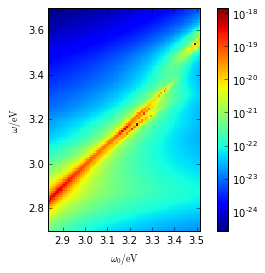

In [62]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LogNorm
%matplotlib inline
plt.imshow(Slist, extent=(ω_0list.min()*ℏ/eV, ω_0list.max()*ℏ/eV, ωlist.min()*ℏ/eV, ωlist.max()*ℏ/eV),
           interpolation='nearest', norm=LogNorm(), origin='lower', cmap=cm.jet
          )
plt.colorbar()
plt.xlabel('$\omega_0/\mathrm{eV}$')
plt.ylabel('$\omega/\mathrm{eV}$')

In [63]:
# Multiple scattering
nmax=60
a = 20e-9 #7e-9
r1 =np.array([[-21e-9,-4.5e-9+i*3e-9,-4.5e-9+j*3e-9] for i in range(4) for j in range(4)])
ω_p = 9*eV/ℏ #9*eV/ℏ
#print(ω_p)
ε_inf = 4.6
γ_p = 0.1*eV/ℏ
ε_b = 2.13
#npart=20
#r1=sph2cart(np.array([[21e-9,π/2.,2*π*fi/npart] for fi in range(npart)]))
npart = r1.shape[0]

γ_QE = 0.015*eV/ℏ # Original Delga: 15 meV. Makes the peak too sharp.
μ = np.array(npart*[[0.38e-9*e,0,0]])
R = np.array([0,1e-6,0]) # detector position
startω = 2.7*eV/ℏ
stopω = 3.7*eV/ℏ
ωlist = np.linspace(startω, stopω, 100)
ω_0list = np.linspace(startω*1.05, stopω*0.95, 90)
Slist = np.empty(shape=(ωlist.shape[0],ω_0list.shape[0]),dtype=float)
Klist = np.empty(shape=(ωlist.shape[0],ω_0list.shape[0],3,3),dtype=np.complex_)
Kselflist = np.empty(shape=(ωlist.shape[0],ω_0list.shape[0],3,3),dtype=np.complex_)
mKmlist = np.empty(shape=(ωlist.shape[0],ω_0list.shape[0],npart,npart,), dtype=np.complex_)
Km_destlist = np.empty(shape=(ωlist.shape[0],ω_0list.shape[0],npart,3), dtype=np.complex_)
G_sourcelist = np.empty(shape=(ωlist.shape[0],ω_0list.shape[0],npart,3), dtype=np.complex_)
Vlist = np.empty(shape=(ωlist.shape[0],ω_0list.shape[0]),dtype=np.complex_)
for i in range(ω_0list.shape[0]):
    ω_0 = ω_0list[i]
    Ω = ω_0+1j*γ_QE
    for j in range(ωlist.shape[0]):
        ω = ωlist[j]
        V = -(ω*ω/(c*c*ε_0*ℏ))*2*Ω.real/(ω*ω-2j*ω*Ω.imag - abs(Ω)**2)
        Vlist[j,i]=V
        
        ε_m = ε_drude(ε_inf, ω_p, γ_p, ω)
        k = ω/c
        k_out = math.sqrt(ε_b)*k
        k_in = cmath.sqrt(ε_m)*k
        RH, RV, TH, TV = mie_coefficients(a, nmax, k_i=k_in, k_e=k_out, μ_i=1, μ_e=1, J_ext=1, J_scat=3)
        #G_Mie_scat_precalc_cart_new(source_cart, dest_cart, RH, RV, a, nmax, k_i=k_in, k_e=k_out, μ_i=1, μ_e=1, J_ext=1, J_scat=3)
        #print ("ε_m",ε_m)
        mKm = np.empty((npart, npart),dtype=np.complex_) # source-dest order
        Km_dest = np.empty((npart,3),dtype=np.complex_)
        Tself = np.empty((npart,),dtype=np.complex_)
        M = np.empty((npart, npart), dtype=np.complex_)
        for n in range(npart): # n is source index
            #print(n,μ[n].shape, r1[n].shape, R.shape)
            Km_dest[n] = np.dot(μ[n], G_Mie_scat_precalc_cart_new(r1[n], R, 
                                                 RH, RV, a, nmax, k_i=k_in, k_e=k_out, μ_i=1, μ_e=1, J_ext=1, J_scat=3) 
                                               + G0_dip_1(R-r1[n],k_out))
            for m in range(npart): # m is dest index
                if(m == n):
                    #fixme pořadí indexů v greenových funkcích je „nepřirozené“
                    mKm[n,m] = np.dot(μ[n], np.dot(G_Mie_scat_precalc_cart_new(r1[n], r1[m], 
                                                 RH, RV, a, nmax, k_i=k_in, k_e=k_out, μ_i=1, μ_e=1, J_ext=1, J_scat=3) 
                                               , μ[m])
                                     )
                else:
                    #print("To ne!")
                    mKm[n,m] = np.dot(μ[n], np.dot(G_Mie_scat_precalc_cart_new(r1[n], r1[m], 
                                                RH, RV, a, nmax, k_i=k_in, k_e=k_out, μ_i=1, μ_e=1, J_ext=1, J_scat=3) 
                                               + G0_dip_1(r1[m]-r1[n],k_out)
                                             , μ[m])
                                     )
            Tself[n] = V/(1-mKm[n,n]*V)
            for m in range(npart):
                if(m==n):
                    M[n,m] = 1
                else:
                    #print("To ne!")
                    M[n,m] = -mKm[n,m]*Tself[n]
        M_inv = np.linalg.inv(M)
        # NB still source dest order. The dipole moments are already included 
        # in mKm, Km_dest, so no need to have them here:
        T = Tself[ň,:]*M_inv[:,:] 
        # Delga supplement, eq.(23): Here we have no free radiation in the initial state.
        # FIXME PROBLÉM TU???
        G_source_n = Km_dest + np.dot(mKm,np.dot(T,Km_dest))
        #print(G_source_n.shape)
        #K     = G_Mie_scat_cart(source_cart=r1, dest_cart=R,  a=a, nmax=nmax, k_i=k_in, k_e=k_out)+G0_dip_1(R-r1,k_out)
        #Klist[j,i]=K
        #mKmlist[j,i]=mKm
        #Km_destlist[j,i]=Km_dest
        #G_sourcelist[j,i]=G_source_n
        #Kself = G_Mie_scat_cart(source_cart=r1, dest_cart=r1, a=a, nmax=nmax, k_i=k_in, k_e=k_out)
        #Kselflist[j,i]=Kself
        # Single QE contribution, eq. (29):
        S_n0 = np.dot(((ω*ω/(c*c*ε_0))*np.linalg.norm(G_source_n, axis=-1))**2 , (
            np.identity(npart)/abs(ω-Ω)**2 + 1/(ω+Ω)**2))
        #den = abs(ω*ω-2j*ω*Ω.imag - abs(Ω)**2 
        #   +2*(ω*ω/(c*c*ε_0*ℏ)) * Ω.real*np.dot(μ,np.dot(Kself,μ)))**2
        Slist[j,i] = np.sum(S_n0)#num/den*2*(ω*ω+abs(Ω)**2)

/home/necadam1/.local/lib/python3.4/site-packages/ipykernel/__main__.py:93: ComplexWarning: Casting complex values to real discards the imaginary part


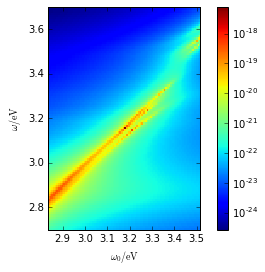

In [64]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LogNorm
%matplotlib inline
plt.imshow(Slist, extent=(ω_0list.min()*ℏ/eV, ω_0list.max()*ℏ/eV, ωlist.min()*ℏ/eV, ωlist.max()*ℏ/eV),
           interpolation='nearest', norm=LogNorm(), origin='lower', cmap=cm.jet
          )
plt.colorbar()
plt.xlabel('$\omega_0/\mathrm{eV}$')
plt.ylabel('$\omega/\mathrm{eV}$')

In [6]:
get_mn_y

<function qpms_c.get_mn_y>